### Dataset Description
Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

### Project overview
Speckle noise is a multiplicative noise that degrades the visual quality of ultrasound images and affects the clinical assessment. Denoising speckle is a very fundamental challenge in the field of Ultrasound imaging as it affects the clinical assessment. In this project, convolutional autoencoders are used to denoise speckle from breast ultrasound images. The results show that the under proper hyperparameter optimization implemented autoencoder performs significantly better than other traditional filters used for denoising.


# **1. Importing Libraries**

In [1]:
import re
import numpy as np 
import pandas as pd
import random
import math
import cv2 
import seaborn as sns
from glob import glob
import os
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input,LeakyReLU,BatchNormalization,Dropout
from tensorflow.nn import atrous_conv2d
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim,mean_squared_error as mse
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# **2. Importing and preprocessing dataset**

In [2]:
path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/*/*.png' 
images = glob(path)
images.sort()

**Comment** <br> 
Number of images for image and its masks are different for benign and malignant images. Some images have two masks.

In [3]:
#creating dictionary of images and masks
image = []
mask = []
count = 1
i= 0
num = len(images)
images_per_class = {}
while i < num-1:
    print(str(count) + "/" + str(num), end="\r")
    img = images[i]
    label = img.split('/')[-2] #get label from image name
    image_name = img.split('/')[-1].split(')')[0] #get image name
    if label not in images_per_class.keys():
        images_per_class[label] = {'image':[],'mask':[]} #make nested dictionory for each label
    
    
    if img.split('/')[-1][-5] == ')': #get the image
        image = cv2.resize(cv2.imread(img,cv2.IMREAD_GRAYSCALE),(128,128)) #read image
        images_per_class[label]['image'].append(image)
        mylist = images[i:]
        r = re.compile(r".*"+re.escape(image_name)+r"\)_mask*.") #look for mask
        masklist = list(filter(r.match, mylist))
        if len(masklist) == 1:
            mask = cv2.resize(cv2.imread(masklist[0]),(128,128))            
            images_per_class[label]['mask'].append(mask)
        else:  #there are two masks
            mask_1 = cv2.imread(masklist[0])
            mask_2 = cv2.imread(masklist[1])
            mask = cv2.resize(cv2.bitwise_or(mask_1,mask_2),(128,128))            
            images_per_class[label]['mask'].append(mask)      
        
    i+=1 
    
    count += 1

In [4]:
#Number of images per class
labels = []
for key,value in images_per_class.items():
    for k,v in value.items():
        labels.extend([k]*len(v))
        print("{0} : {1} : {2} ".format(key,k, len(v)))

benign : image : 437 
benign : mask : 437 
malignant : image : 210 
malignant : mask : 210 
normal : image : 133 
normal : mask : 133 


Text(0.5, 1.0, 'Mask')

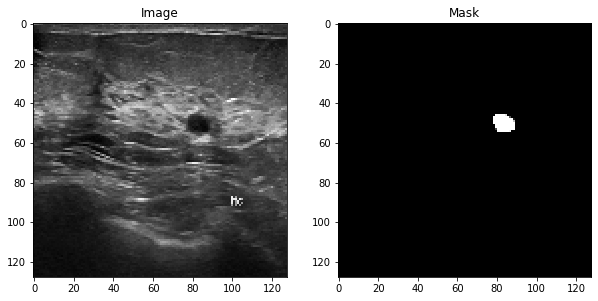

In [5]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(images_per_class['benign']['image'][100])
ax[0].set_title('Image')
ax[1].imshow(images_per_class['benign']['mask'][100])
ax[1].set_title('Mask')

# **3. Denoising Ultrasound Images**

### Creating dataset

In [6]:
#dataset for denoising consists of only images
dataset = images_per_class['benign']['image'] + images_per_class['malignant']['image'] + images_per_class['normal']['image']

In [7]:
#normalizing pixel values in the dataset
dataset = [img/255 for img in dataset] #for faster computation
random.shuffle(dataset)

In [8]:
#Plotting set of images
def plot_images(dataset):
  fig,ax=plt.subplots(1,5)
  fig.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i], cmap='gray')
  plt.show()

In [9]:
noised_dataset=[]
for img in dataset:
  noisy=random_noise(img,mode = 'speckle') #introducing speckle noise
  noised_dataset.append(noisy)

noised_dataset=np.array(noised_dataset)

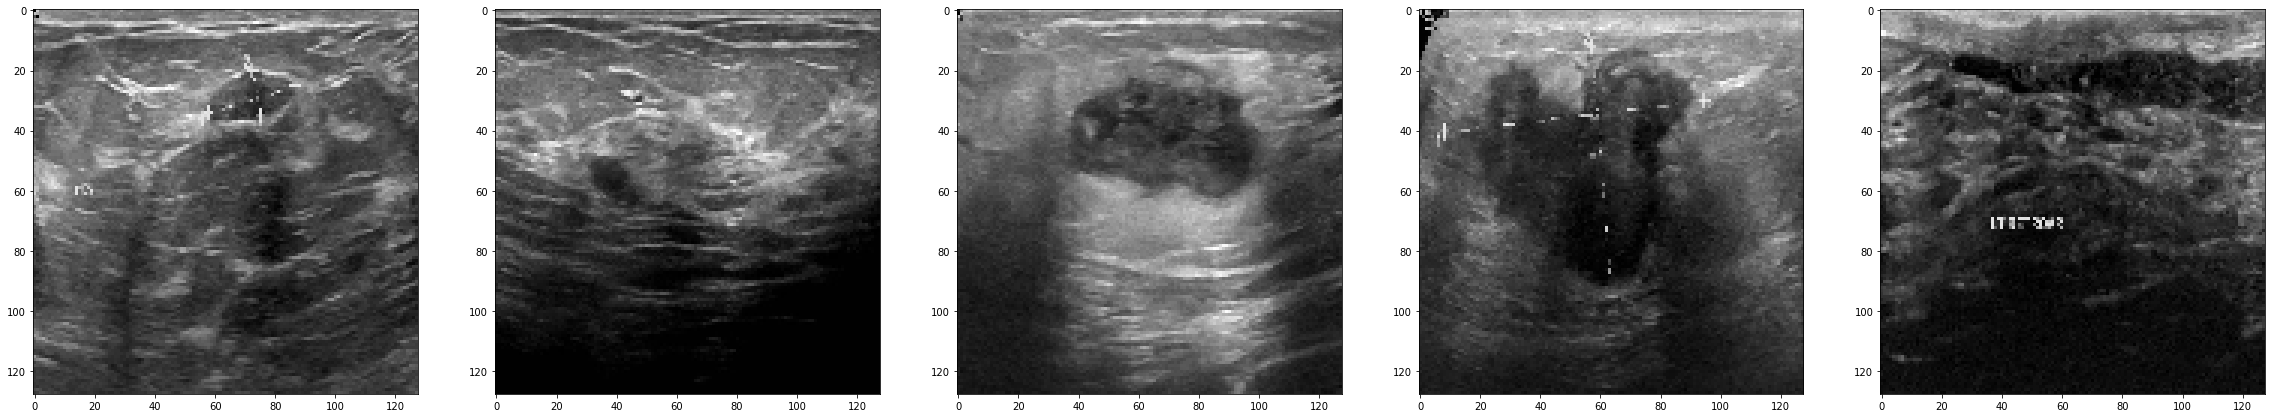

In [10]:
plot_images(dataset)

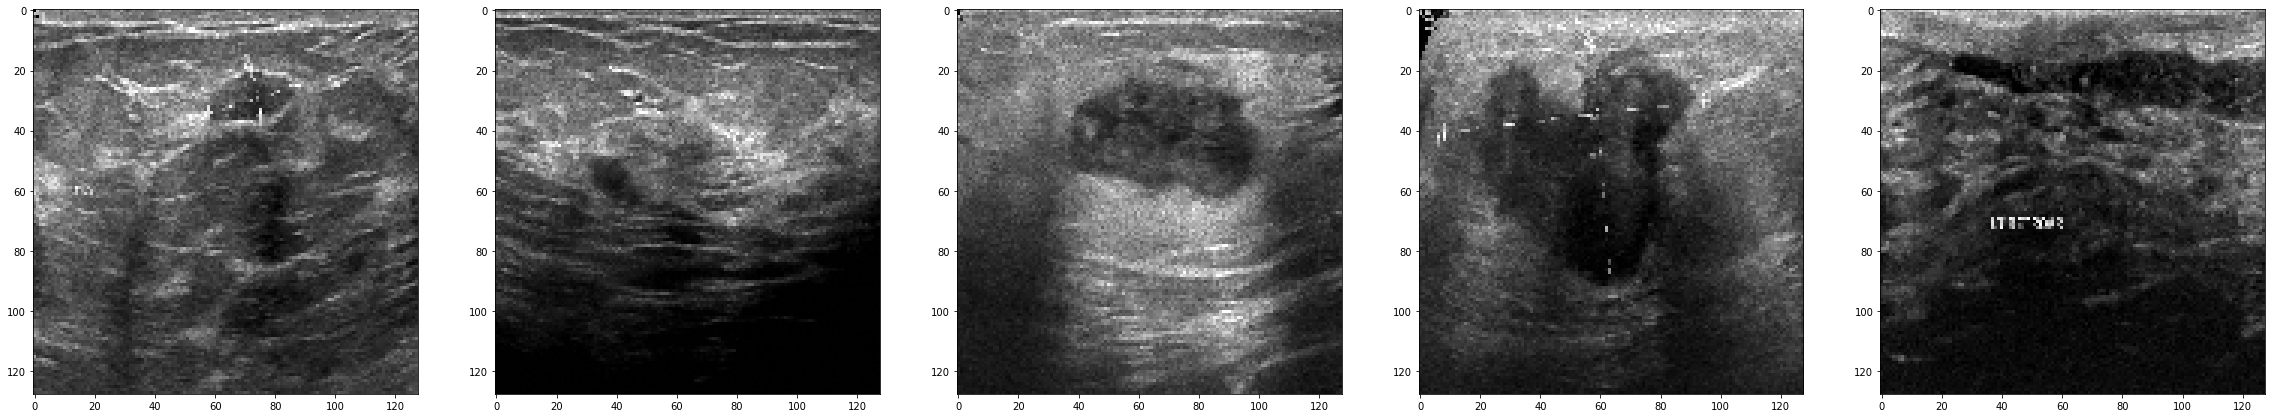

In [11]:
plot_images(noised_dataset)

In [12]:
#Splitting dataset for training and testing
x_train = noised_dataset[:500]
x_train_clean = dataset[:500]
x_test=noised_dataset[500:]
x_test_clean = dataset[500:]

### Building model architecture

In [13]:
def denoising_autoencoder():
    i=Input(shape=(128,128,1))
    #encoder 
    x = Conv2D(128, (3,3), activation='relu', padding='same')(i)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)

    #decoder
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

    #model
    autoencoder = Model(inputs=i, outputs=x)
    autoencoder.compile(optimizer='Adam', loss='mse')
    autoencoder.summary()

    return autoencoder


In [14]:
autoencoder = denoising_autoencoder()

2021-10-18 01:30:56.866055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584

2021-10-18 01:30:56.952007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 01:30:56.952730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 01:30:56.953806: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-18 01:30:56.954925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### Training the  model

In [15]:
epochnum = 300
batchnum = 64

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=8, 
                                            verbose=1, 
                                            factor=0.8, 
                                            min_lr=1e-10)
r = autoencoder.fit(x_train, x_train,
                epochs=epochnum,
                batch_size=batchnum,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[learning_rate_reduction],verbose=0)
#model evaluation
print("Train score:", autoencoder.evaluate(x_train,x_train))
print("Test score:", autoencoder.evaluate(x_test,x_test))

2021-10-18 01:30:59.590209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-18 01:31:00.947958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00061: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 00087: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 00096: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 00106: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 00116: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.

Epoch 00141: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.

Epoch 00164: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.

Epoch 00178: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 8.589935605414213e-05.

Epoch 00194: ReduceLROnPlateau reducing learning rate to 6.871948717162013e-05.

Epoch 00202: ReduceLRO

### Get prediction

In [16]:
pred= autoencoder.predict(x_test[:5])

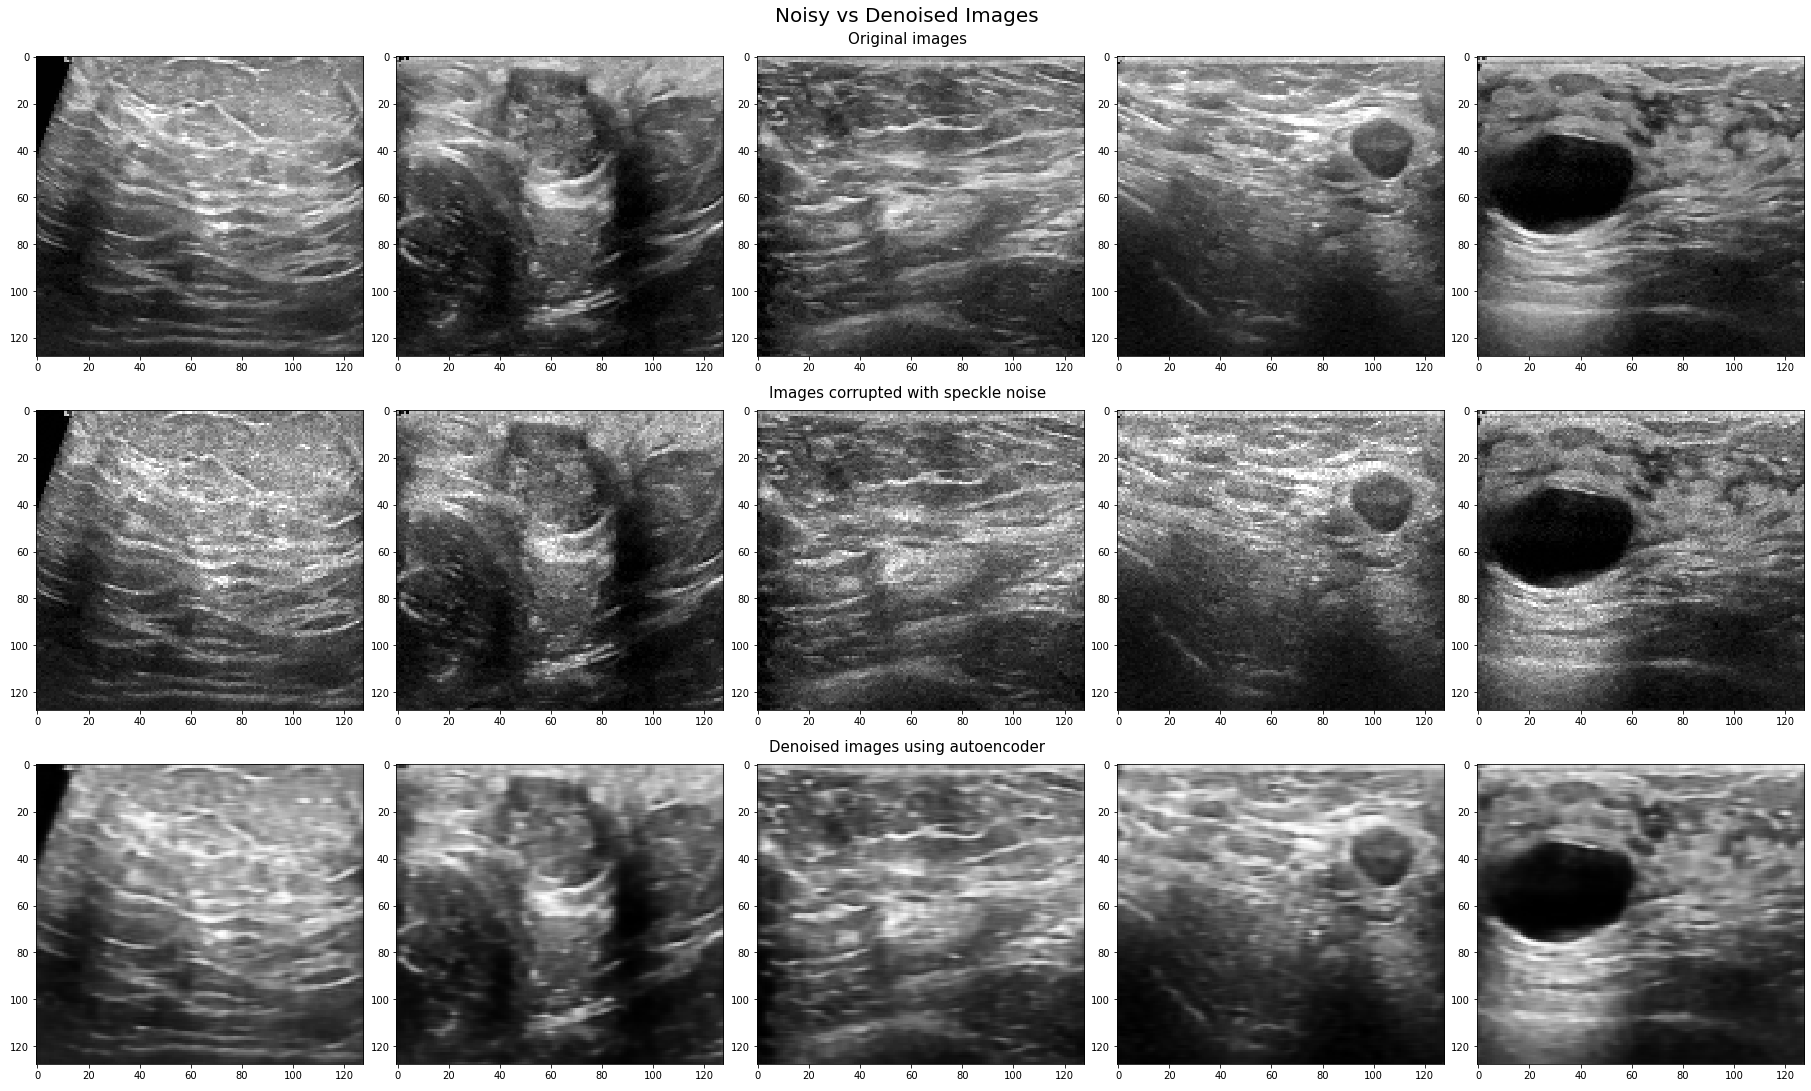

In [17]:
image_dict = {0 :x_test_clean,1:x_test,2:pred}
title = ['Original images','Images corrupted with speckle noise','Denoised images using autoencoder']

fig, axs = plt.subplots(nrows=3, ncols=1, figsize = (25,15),constrained_layout=True)
fig.suptitle('Noisy vs Denoised Images',fontsize = 20)

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    subfig.suptitle(title[row],fontsize=15)

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=5)
    for col, ax in enumerate(axs):
        ax.imshow(image_dict[row][col], aspect='auto', cmap='gray')

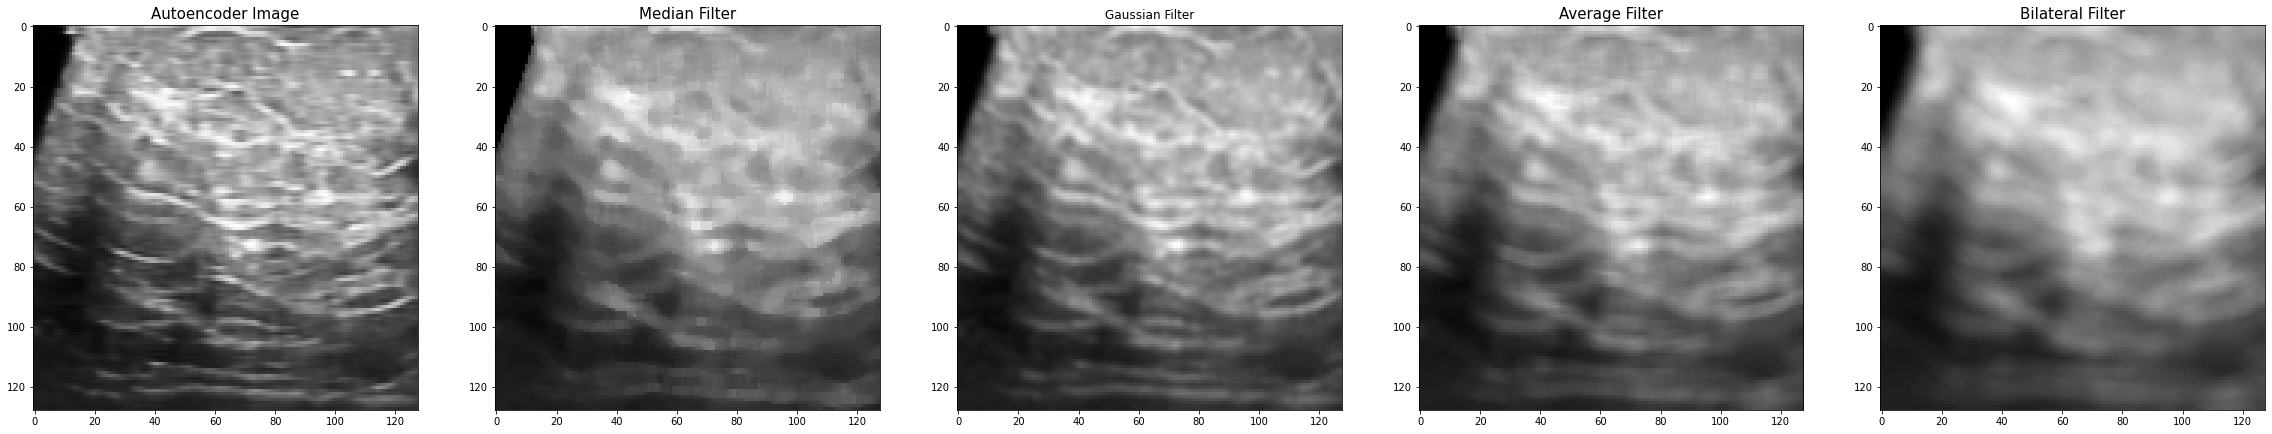

In [18]:
median_blur = cv2.medianBlur(np.float32(x_test[0]), (5))
gaussian_blur=cv2.GaussianBlur(x_test[0],(5,5),0)
average_blur=cv2.blur(x_test[0],(5,5))
bilateral_filter=cv2.bilateralFilter(np.float32(x_test[0]),9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(pred[0], cmap='gray')
ax[0].set_title('Autoencoder Image',fontsize = 15)
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter',fontsize = 15)
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur,cmap='gray')
ax[3].set_title('Average Filter',fontsize = 15)
ax[4].imshow(bilateral_filter,cmap='gray')
ax[4].set_title('Bilateral Filter',fontsize = 15)
plt.show()

In [19]:
def plotLearningCurve(history,epochnum,batchnum):
  epochRange = range(1,epochnum+1)
  plt.figure(figsize = (5,5))
  plt.plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  plt.plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  plt.xlabel('Epoch', fontsize = 15)
  plt.ylabel('Loss', fontsize = 15)
  plt.grid(color='gray', linestyle='--')
  plt.legend()
  plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
  plt.show()

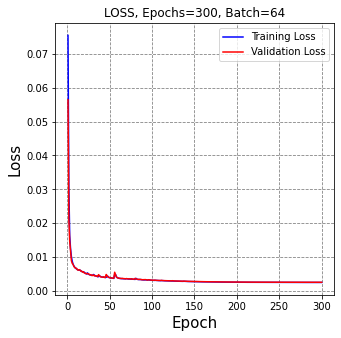

In [20]:
plotLearningCurve(r,epochnum,batchnum)

### Metric Evaluation

In [21]:
value1 = psnr(x_test[0], pred[0].reshape(x_test_clean[0].shape[0],-1))
value2 = psnr(x_test[0], median_blur)
value3 = psnr(x_test[0], gaussian_blur)
value4 = psnr(x_test[0], average_blur)
value5 = psnr(x_test[0], bilateral_filter)
metric = pd.DataFrame({'Autoencoder':value1,'Median Blur':value2,'Gaussian Blur':value3,'Average Blur':value4,'Bilateral Filter':value5},index = ['PSNR'])
value1 = mse(x_test[0], pred[0].reshape(x_test_clean[0].shape[0],-1))
value2 = mse(x_test[0], median_blur)
value3 = mse(x_test[0], gaussian_blur)
value4 = mse(x_test[0], average_blur)
value5 = mse(x_test[0], bilateral_filter)
metric.loc['MSE'] = [value1,value2,value3,value4,value5]
value1 = ssim(x_test[0], pred[0].reshape(x_test_clean[0].shape[0],-1))
value2 = ssim(x_test[0], median_blur)
value3 = ssim(x_test[0], gaussian_blur)
value4 = ssim(x_test[0], average_blur)
value5 = ssim(x_test[0], bilateral_filter)
metric.loc['SSIM'] = [value1,value2,value3,value4,value5]
metric


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


,Autoencoder,Median Blur,Gaussian Blur,Average Blur,Bilateral Filter
PSNR,24.312554,21.478682,23.349036,21.400930,20.653280
MSE,0.003705,0.007114,0.004625,0.007243,0.008603
SSIM,0.811648,0.599396,0.741761,0.581080,0.496948
